Instale e importe os pacotes necessário, faça o unzip dos dados de treinamento

In [9]:
!pip install Unidecode

In [10]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [11]:
import os
import random
from string import ascii_letters

import torch
from torch import nn
import torch.nn.functional as F
from unidecode import unidecode

from sklearn.model_selection import train_test_split

O objetivo desse laboratório e nos familiarizarmos com a implementação de Redes Neurais Recorrentes e com o uso da biblioteca PyTorch.

Faremos a implementação de uma RNN que recebe como entrada uma sequência de caractéres, representando o nome ou sobrenome de uma pessoa (ex: Silveira), e prediz (classifica) qual a origem/nacionalidade daquele nome (ex: Português).

A RNN irá operar no nível do caracter (character-level RNN), ou seja: o nome como um todo representa uma sequência de letras, e cada unidade da RNN recebe a uma letra como entrada.

A forma geral da nossa RNN é a seguinte:

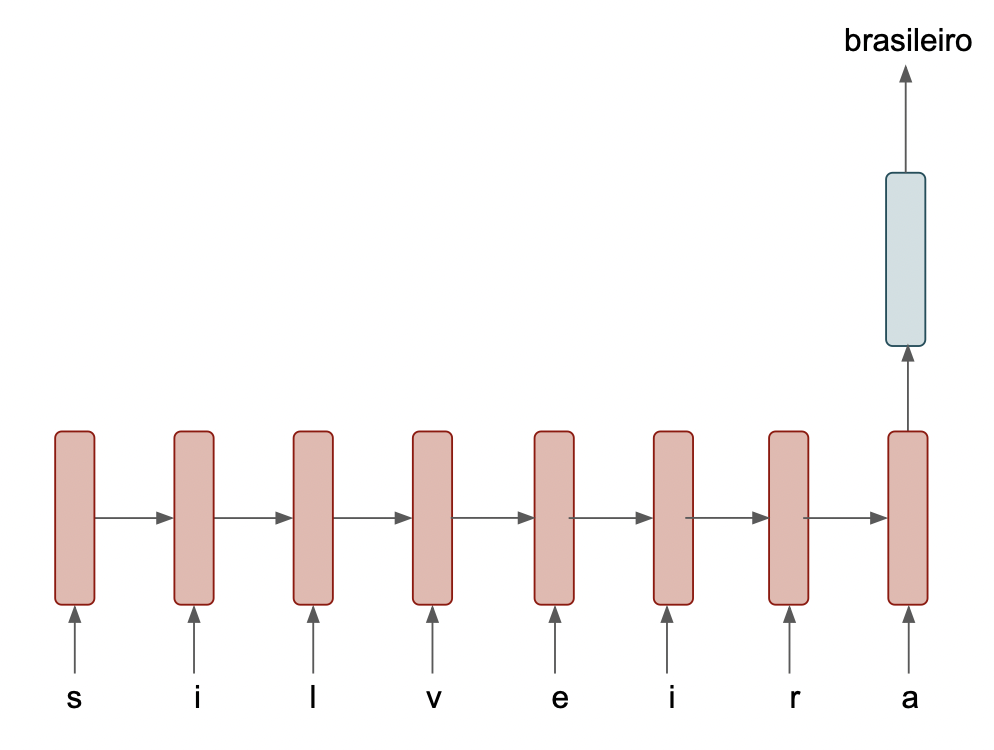

Durante o laboratório, caso haja dificuldade na utilização da biblioteca PyTorch, recomendo estudar o tutorial disponibilizado na página da disciplina (o link do tutorial está disponível nas Aulas 1 e 6).

A célula abaixo mostra os arquivos que utilizaremos para treinamento de nossa RNN. A pasta `names` conta com uma série de arquivos `txt` nomeados de acordo com certa nacionalidade, e esses arquivos contém uma série de nomes daquela nacionalidade.

In [12]:
data_dir = "./data/names"
print("Arquivos com dados para treinamento da RNN:")
print(os.listdir(data_dir))
print("Número de nacionalidades (categorias) que nossa RNN irá classificar: {}".format(len(os.listdir(data_dir))))

Arquivos com dados para treinamento da RNN:
['Russian.txt', 'Chinese.txt', 'Spanish.txt', 'Czech.txt', 'Vietnamese.txt', 'Italian.txt', 'Scottish.txt', 'Portuguese.txt', 'Arabic.txt', 'Dutch.txt', 'English.txt', 'Japanese.txt', 'Polish.txt', 'Irish.txt', 'Greek.txt', 'French.txt', 'Korean.txt', 'German.txt']
Número de nacionalidades (categorias) que nossa RNN irá classificar: 18


A célula abaixo cria um dicionário que faz o mapeamento de cada nacionalidade para um rótulo correspondente:

In [13]:
# create dictionary that maps a language to a numerical label
lang2label = {
    file_name.split(".")[0]: torch.tensor([i], dtype=torch.long)
    for i, file_name in enumerate(os.listdir(data_dir))
}
print(lang2label)
print("Exemplo - Rótulo da nacionalidade portuguesa:")
print(int(lang2label["Portuguese"]))

{'Russian': tensor([0]), 'Chinese': tensor([1]), 'Spanish': tensor([2]), 'Czech': tensor([3]), 'Vietnamese': tensor([4]), 'Italian': tensor([5]), 'Scottish': tensor([6]), 'Portuguese': tensor([7]), 'Arabic': tensor([8]), 'Dutch': tensor([9]), 'English': tensor([10]), 'Japanese': tensor([11]), 'Polish': tensor([12]), 'Irish': tensor([13]), 'Greek': tensor([14]), 'French': tensor([15]), 'Korean': tensor([16]), 'German': tensor([17])}
Exemplo - Rótulo da nacionalidade portuguesa:
7


Armazene o número de línguas (rótulos) do problema:

In [14]:
# store the number of languages
num_langs = len(lang2label)
print("[INFO] número de línguas: {}".format(num_langs))

[INFO] número de línguas: 18


Utilizaremos o pacote unidecode para fazer limpeza de nossos dados, removendo símbolos e acentos dos nomes. Veja o exemplo:

In [15]:
# unidecode remove symbols/accents from the names
# example
print(unidecode("Ślusàrski"))

Slusarski


A célula abaixo cria um dicionário que mapeia um caracter para um `id` correspondente. Isso será útil para mapear cada caracter para um vetor `one-hot`.

In [16]:
# we will be working with character level
# so we create a dictionary that maps char to index
char2idx = {letter: i for i, letter in enumerate(ascii_letters + " .,:;-'")}
num_letters = len(char2idx)
# print(char2idx)
print("Número total de caractéres: {}".format(num_letters))

Número total de caractéres: 59


Contamos com 59 caractéres no total. Assim, representaremos cada caracter como um vetor one-hot com 59 dimensões.

Desse modo, um nome será representado na seguinte forma: `[len_name, input_size]`, onde `len_name` é o comprimento do nome e `input_size` é o número de caractéres total (59).

Porém, caso utilizemos um batch de dados para o treinamento, precisamos de uma dimensão para nosso batch. Desse modo, representaremos nossos dados no seguinte formato:

`[len_name, batch_size, input_size]`

Exemplo: batch contendo apenas o nome `Silveira`:

`[8, 1, 59]`

A função abaixo faz exatamente isso: recebe um nome, e retorna um tensor no formato `[len_name, batch_size, input_size]`.


In [17]:
# each name will be expressed as a tensor of shape (num_chars, batch_size, 59)
# that is: each character will be a tensor of size 59

# function to map names to its corresponding tensors
def name2tensor(name):
    # tensor shape (seq_len, batch_size, input_size)
    # batch size of 1
    tensor = torch.zeros(len(name), 1, num_letters)
    for i, char in enumerate(name):
        tensor[i][0][char2idx[char]] = 1
    return tensor

Precisamos gerar nosso dataset a partir dos arquivos txt. Na célula abaixo, fazemos um loop por todos os arquivos txt, limpamos cada um dos nomes utilizando a função `unidecode` para remoção de símbolos e acentos, e `rstrip` para remoção de espaços após a palavra.

Adicionamos então o nome pré-processando e sua nacionalidade para as listas `tensor_names` e `target_langs`, que são os dados de entradas e rótulos para nossa rede neural.

In [18]:
tensor_names = []
target_langs = []

for file in os.listdir(data_dir):
    # with open(os.path.join(data_dir, file)) as f:
    with open(os.path.join(data_dir, file), encoding="utf8") as f:
        lang = file.split(".")[0]
        # rstrip() removes trailing characters
        names = [unidecode(line.rstrip()) for line in f]
        for j, name in enumerate(names):
            try:
                tensor_names.append(name2tensor(name))
                target_langs.append(lang2label[lang])
            except KeyError:
                pass

print("Comprimento da lista tensor_names: {}".format(len(tensor_names)))
print("Comprimento da lista target_langs: {}".format(len(target_langs)))

Comprimento da lista tensor_names: 20070
Comprimento da lista target_langs: 20070


Fazemos a partição de nossos dados usando a função `train_test_split`, separando 10% de nossos dados para teste.

In [19]:
# split the data indexes into train and test
train_idx, test_idx = train_test_split(range(len(target_langs)),
                                       test_size=0.1, shuffle=True, stratify=target_langs)

train_dataset = [
    (tensor_names[i], target_langs[i])
    for i in train_idx
]

test_dataset = [
    (tensor_names[i], target_langs[i])
    for i in test_idx
]

print("")
print("Tamanho dataset de treino: {}".format(len(train_dataset)))
print("Tamanho dataset de teste: {}".format(len(test_dataset)))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)



Tamanho dataset de treino: 18063
Tamanho dataset de teste: 2007


A célula abaixo traz a implementação de uma RNN simples, conforme vista em aula (exceto a aplicação da função `softmax`, que não está implementada. A função de perda de entropia cruzada fornecida pelo PyTorch implementa a função `softmax` para nós internamente.).

Note que uma unidade RNN tem duas saídas, o `output` (após passar pela camada `U`) e um `hidden state h`, que será alimentado para a próxima unidade RNN.

Utilizaremos o `output` apenas da última unidade RNN da nossa sequência, que será responsável por predizer a nacionalidade do nome analisado.

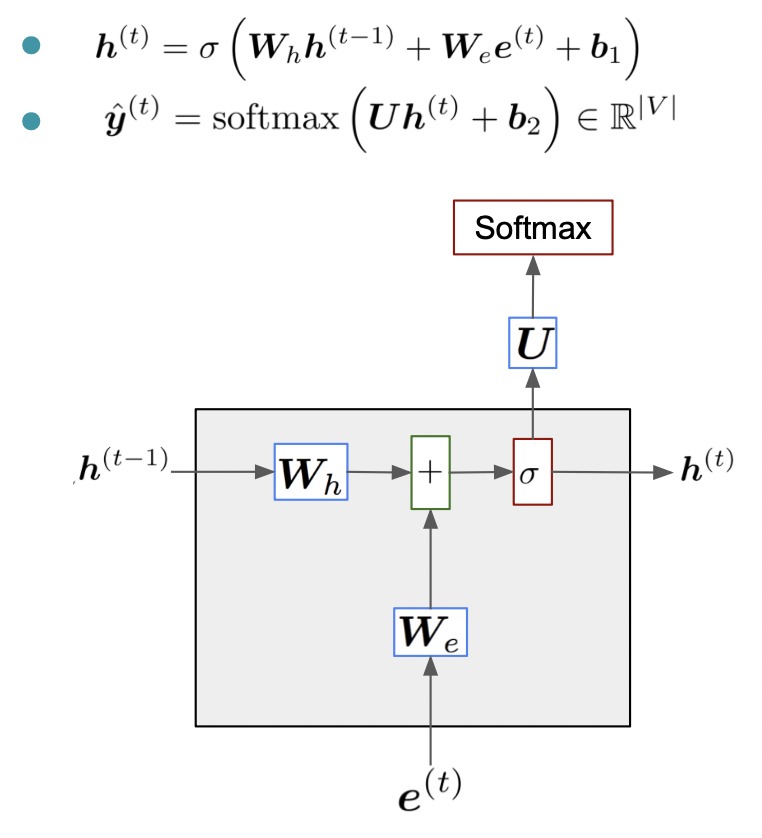

Note a seguinte equivalência entre o formato da equação do `hidden layer` vista em sala e implementada abaixo:

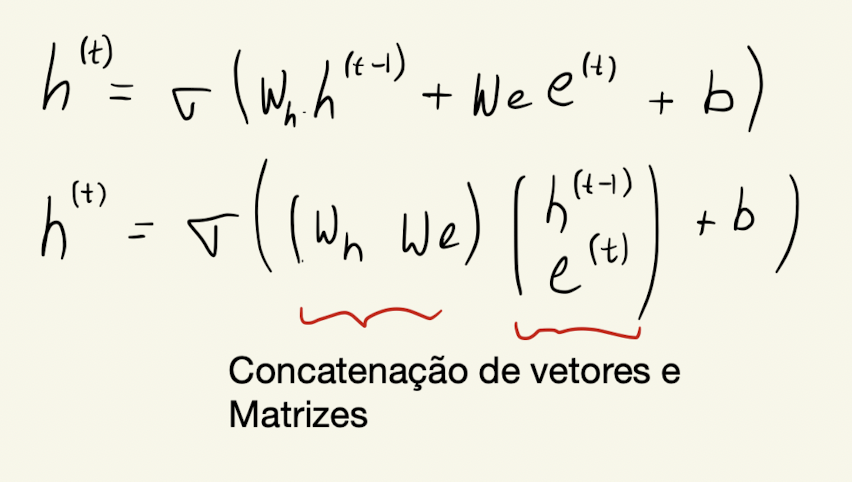

`class SimpleRNN(nn.Module)` traz a implementação de uma unidade da RNN simples.

Os seguintes argumentos são necessário para inicializar essa classe:

1. `input_size`: tamanho do one-hot vector que representa cada carácter.

2. `hidden_size`: dimensão do vetor de `hidden-state`.

3. `output_size`: dimensão do vetor de saída, ou seja, a quantidade de classes que queremos predizer. No nosso caso, o número de nacionalidades possíveis.

Ao inicializar a `SimpleRNN`, duas camadas de rede neural são criada:

1. `self.W = nn.Linear(input_size + hidden_size, hidden_size)`:

A camada `self.W` é responsável por gerar o `hidden_state` atualizado da RNN. Ela recebe o vetor `hidden_state` da RNN anterior concatenado com o input da RNN, que é o one-hot vector de um caracter da sequência (essa concatenação gera um vetor de tamanho `input_size + hidden_size`). E ela gera o novo vetor `hidden_state` com dimensão `hidden_size`.

O método `forward` implementa o forward propagation na nossa unidade RNN.

2. `self.U = nn.Linear(hidden_size, output_size)`:

A camada `self.U` recebe o `hidden_state` atualizado da unidade RNN e gera o vetor de `output`, que tem como dimensão o número de categorias que a rede pode predizer (número de nacionalidades).

Para realização do forward propagation, os seguintes inputs são necessário:

1. `x`: input para a unidade RNN. No nosso caso, será um one-hot vector do carácter da sequência.

2. `previous_hidden_state`: vetor de `hidden_state` processado pela unidade RNN anterior.

O método forward concatena suas duas entradas, `x` e `previous_hidden_state`, antes de passá-los como input para a camada de rede neural `self.W`. Então, o output dessa camada é passada por uma função não linear tangente hiperbólica, que gera o novo `hidden_state` atualizado.

O `hidden` passa então pela camada de rede neural `self.U`, para gerar o vetor de output da unidade RNN.

O método `forward` retorna o `output` da unidade RNN e o `hidden_state` atualizado.

Além disso, a classe SimpleRNN conta com o método `init_hidden`, que tem como função gerar um vetor de estado inicial, preechido por zeros.

In [20]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        # input size is the total number of letters (the size of the input vector at each position of the name)
        # hidden size is the dimension of the hidden state vector
        # output size is the number of classes the model can predict (number of nationalities)

        self.hidden_size = hidden_size

        # concatenated matrices (Wh We)
        self.W = nn.Linear(input_size + hidden_size, hidden_size)
        # output layer to get the prediction
        self.U = nn.Linear(hidden_size, output_size)

    def forward(self, x, previous_hidden_state):
        # concatenate the input to the RNN unit and hidden state of the previous time-step
        combined = torch.cat((x, previous_hidden_state), 1)
        # pass the combined vector throught the RNN layer
        hidden = torch.tanh(self.W(combined))
        # pass the hidden state throught the output layer
        output = self.U(hidden)
        # return the output for the RNN unit and the hidden state
        return output, hidden

    # we call init_hidden at the start of every batch
    def init_hidden(self):
        # initialization for the initial hidden state
        return nn.init.zeros_(torch.empty(1, self.hidden_size))

Faça o treinamento da nossa RNN para a tarefa de predizer a nacionalidade de um dado nome (estude com atenção a célula abaixo):

In [21]:
# size of the hidden state
hidden_size = 256
# learning rate
learning_rate = 0.001

# initilize our model
model1 = SimpleRNN(input_size=num_letters,
                   hidden_size=hidden_size,
                   output_size=num_langs)

# we will use the CrossEntropy Loss function - it expects the unnormalized logits
# from the RNN, so do not use softmax before it
criterion = nn.CrossEntropyLoss()

# we will use Adam as our optimizer, because upon trial and error, it was observed
# that it works considerably better than SGD for this task
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)

# we will train for only 2 epochs, in order to be reasonably fast
num_epochs = 2
# print information every 3000 words
print_interval = 3000

# put the model in train mode
model1.train()

# run the training - in each epoch, the model is trained on all data from the dataset
for epoch in range(num_epochs):
    # shuffle the data
    random.shuffle(train_dataset)

    # loop through every example in the train_dataset, and feed it one at a time to the NN
    # we will train with batch_size of 1 for simplicity
    for i, (name, label) in enumerate(train_dataset):

        # initilize hidden state at the beginning of every batch
        hidden_state = model1.init_hidden()

        # loop through the characters of the word
        for char in name:
            # execute the RNN for every character, feeding back in the hidden state
            output, hidden_state = model1(char, hidden_state)

        # the last output of the NN is used for the loss computation and prediction of nationality for the word
        loss = criterion(output, label)

        # before each step of learning, you need to zero the gradients of the computation graph
        optimizer.zero_grad()

        # calculate the gradients through backpropagation
        loss.backward()

        # clip the gradients - avoid exploding gradients
        nn.utils.clip_grad_norm_(model1.parameters(), 1)

        # make one optimization step
        optimizer.step()

        if (i + 1) % print_interval == 0:
            print("Epoch [{}/{}], Step [{}, {}], Loss: {}".format(
                epoch, num_epochs, i, len(train_dataset), loss))

Epoch [0/2], Step [2999, 18063], Loss: 0.0006718761869706213
Epoch [0/2], Step [5999, 18063], Loss: 6.103329360485077e-05
Epoch [0/2], Step [8999, 18063], Loss: 6.6374287605285645
Epoch [0/2], Step [11999, 18063], Loss: 7.306102275848389
Epoch [0/2], Step [14999, 18063], Loss: 0.02315680868923664
Epoch [0/2], Step [17999, 18063], Loss: 0.0007030876004137099
Epoch [1/2], Step [2999, 18063], Loss: 7.6249613761901855
Epoch [1/2], Step [5999, 18063], Loss: 0.16407698392868042
Epoch [1/2], Step [8999, 18063], Loss: 10.25832748413086
Epoch [1/2], Step [11999, 18063], Loss: 0.4870501756668091
Epoch [1/2], Step [14999, 18063], Loss: 0.004974251613020897
Epoch [1/2], Step [17999, 18063], Loss: 4.8874615458771586e-05


Calcule a acurácia de nossa RNN simples:

In [22]:
num_correct = 0
num_samples = len(test_dataset)

# put the model in evaluation mode
model1.eval()

# turn off gradients calculation
with torch.no_grad():
    for name, label in test_dataset:
        hidden_state = model1.init_hidden()
        for char in name:
            output, hidden_state = model1(char, hidden_state)

        # get the index with maximum output - this is the class predicted
        _, pred = torch.max(output, dim=1)
        num_correct += bool(pred == label)

print("Acurácia: {:.2f}%".format(num_correct/num_samples * 100))

Acurácia: 68.66%


Tarefa 1 (2 pontos)

Agora é a sua vez, faça a implementação de uma LSTM:

Dica 1: multiplicação element-wise de dois vetores em pytorch pode ser feita simplesmente pelo operador `*`.

Dica 2: Após o cálculo do novo `hidden-state h` da unidade LSTM, é necessário calcular o output da LSTM, passando o `hidden-state` por mais uma camada linear. O output da última unidade LSTM de cada palavra irá ser usado para cálculo da predição final.

Para consulta, seguem as equações necessárias para a LSTM e o cálculo de seu output:

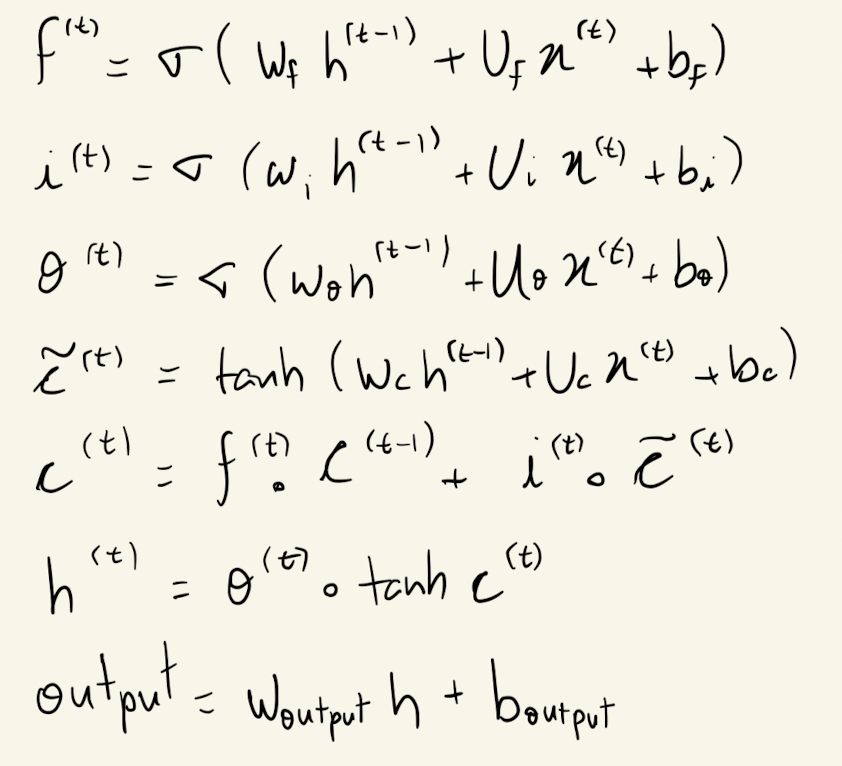

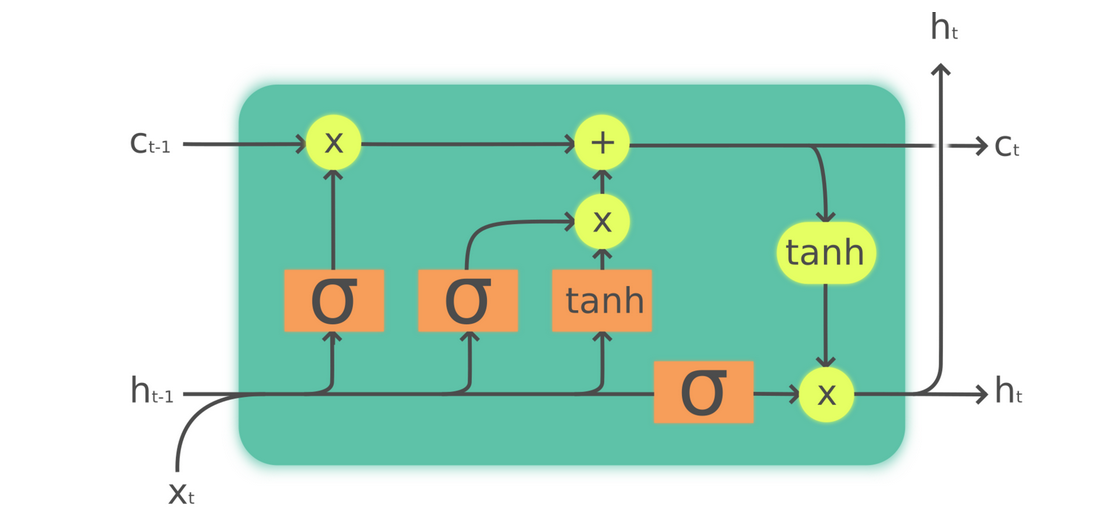

In [23]:
# https://pt.d2l.ai/chapter_recurrent-modern/lstm.html
# https://kushalj001.github.io/black-box-ml/lstm/pytorch/gates/vanishing%20gradient/2019/12/28/Understanding-LSTMs.html#Cell-update
# https://docs.kanaries.net/pt/tutorials/Python/nn-linear
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTM, self).__init__()
    # input size is the number of letters (the size of the input vector at
    # ... each position of the name)
    # hidden size is the size of the hidden size vector
    # output size is the number of classes the model can predict

    # TO DO

    self.hidden_size = hidden_size
    self.input_size = input_size
    self.output_size = output_size
    # forget gate
    self.Wf = nn.Linear(input_size + hidden_size, hidden_size)
    # input gate
    self.Wi = nn.Linear(input_size + hidden_size, hidden_size)
    # output gate
    self.Wo = nn.Linear(input_size + hidden_size, hidden_size)
    # cell state
    self.Wc = nn.Linear(input_size + hidden_size, hidden_size)

    # layer to calculate the output of the LSTM unit
    self.U = nn.Linear(hidden_size, output_size)
    # TO DO

  def forward(self, x, previous_hidden_state, previous_cell_state):
    # inputs: input vector, previous hidden state and previous cell state

    # TO DO

    # concatenate the input to the RNN unit and hidden state of the previous time-step
    combined = torch.cat((x, previous_hidden_state), 1)

    forget_gate = torch.sigmoid(self.Wf(combined))
    input_gate = torch.sigmoid(self.Wi(combined))
    cell_gate = torch.tanh(self.Wc(combined))
    output_gate = torch.sigmoid(self.Wo(combined))

    cell_state = (forget_gate * previous_cell_state) + (input_gate * cell_gate)
    hidden_state = output_gate * torch.tanh(cell_state)

    output = self.U(hidden_state)

    # TO DO

    # the lstm returns 3 vectors: its output, its hidden-state and its cell-state
    return output, (hidden_state, cell_state)

  # we call init_hidden at the start of every batch
  def init_hidden(self):
    # initialization for the initial hidden state
    return nn.init.zeros_(torch.empty(1, self.hidden_size))

Tarefa 2 (2 pontos)

Faça o treinamento da LSTM que você implementou. Note que agora é necessário inicializar ambos vetor de `hidden-state` e `cell-state`.


In [24]:
hidden_size = 256
learning_rate = 0.001

model = LSTM(num_letters, hidden_size, num_langs)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 2
print_interval = 3000

# put the model in train mode
model.train()

for epoch in range(num_epochs):
  random.shuffle(train_dataset)
  for i, (name, label) in enumerate(train_dataset):

    # TO DO

    # initilize hidden state at the beginning of every batch
    hidden_state = model.init_hidden()
    cell_state = model.init_hidden()

    # loop through the characters of the word
    for char in name:
        # execute the RNN for every character, feeding back in the hidden state
        output, (hidden_state, cell_state) = model(char, hidden_state, cell_state)
    # the last output of the NN is used for the loss computation and prediction of nationality for the word
    loss = criterion(output, label)
    # before each step of learning, you need to zero the gradients of the computation graph
    optimizer.zero_grad()
    # calculate the gradients through backpropagation
    loss.backward()
    # clip the gradients - avoid exploding gradients
    nn.utils.clip_grad_norm_(model.parameters(), 1)
    # make one optimization step
    optimizer.step()
    # TO DO
    if (i + 1) % print_interval == 0:
      print("Epoch [{}/{}], Step [{}, {}], Loss: {}".format(
        epoch, num_epochs, i, len(train_dataset), loss))

Epoch [0/2], Step [2999, 18063], Loss: 0.5562931895256042
Epoch [0/2], Step [5999, 18063], Loss: 0.0032283354084938765
Epoch [0/2], Step [8999, 18063], Loss: 2.1043903827667236
Epoch [0/2], Step [11999, 18063], Loss: 7.998623186722398e-05
Epoch [0/2], Step [14999, 18063], Loss: 1.8596476365928538e-05
Epoch [0/2], Step [17999, 18063], Loss: 3.111314072157256e-05
Epoch [1/2], Step [2999, 18063], Loss: 6.235315799713135
Epoch [1/2], Step [5999, 18063], Loss: 6.735097849741578e-05
Epoch [1/2], Step [8999, 18063], Loss: 0.1002030223608017
Epoch [1/2], Step [11999, 18063], Loss: 8.165503095369786e-05
Epoch [1/2], Step [14999, 18063], Loss: 7.931493759155273
Epoch [1/2], Step [17999, 18063], Loss: 0.014744244515895844


Calcule a acurácia de sua implementação (deve estar entre 75% e 85%).

In [25]:
num_correct = 0
num_samples = len(test_dataset)

model.eval()

with torch.no_grad():
  for name, label in test_dataset:
    hidden_state = model.init_hidden()
    cell_state = model.init_hidden()
    for char in name:
      output, (hidden_state, cell_state) = model(char, hidden_state, cell_state)
    # output shape: [1, 18]
    _, pred = torch.max(output, dim=1)
    num_correct += bool(pred==label)

print("Accuracy: {:.2f}%".format(num_correct/num_samples * 100))

Accuracy: 80.07%


Abaixo segue a implementação da RNN simples, agora utilizando a camada RNN fornecida pelo pytorch:

https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

Note que os cálculos internos agora são realizados internamente pela implementação do PyTorch: precisamos apenas alimentar a sequência inteira para RNN, e ela toma conta de realizar o loop por cada valor da sequência.

Desse modo, a entrada para o `forward` método da classe `SimpleRNNWithPyTorch` será a sequência inteira: `x`, com formato `x.shape: (seq_length, batch_size, input_size)`.

Note também que o output `out` dessa implementação é o output apenas da última unidade da RNN, designado por `out[-1]`.

In [26]:
class SimpleRNNWithPyTorch(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(SimpleRNNWithPyTorch, self).__init__()
    # input size is the number of letters (the size of the input vector at each position of the name)
    # hidden size is the size of the hidden size vector
    # output size is the number of classes the model can predict

    self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size)
    self.U = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    # x in the format: (seq_length, batch_size, input_size)
    out, _ = self.rnn(x)
    # we pass the output only of the last RNN unit to calculate the predictions
    out = self.U(out[-1])
    return out


Abaixo fazemos o treinamento da nossa RNN simples baseada na camada fornecida pelo pytorch. Note como a implementação ficou mais simples, e não precisamos mais criar for-loops - o pytorch implementa eles internamente para nós.

In [27]:
hidden_size = 256
learning_rate = 0.001

# declare our model, our loss function and our optimizer
model2 = SimpleRNNWithPyTorch(num_letters, hidden_size, num_langs)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

num_epochs = 2
print_interval = 3000

model2.train()

for epoch in range(num_epochs):
  random.shuffle(train_dataset)
  for i, (name, label) in enumerate(train_dataset):

    output = model2(name)
    output = output.view(1,-1) # reshape output to the shape [1, n_classes]
    loss = criterion(output, label)

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model2.parameters(), 1)
    optimizer.step()

    if (i + 1) % print_interval == 0:
      print("Epoch [{}/{}], Step [{}, {}], Loss: {}".format(
        epoch, num_epochs, i, len(train_dataset), loss))

Epoch [0/2], Step [2999, 18063], Loss: 0.6298069357872009
Epoch [0/2], Step [5999, 18063], Loss: 3.626473903656006
Epoch [0/2], Step [8999, 18063], Loss: 0.06445731967687607
Epoch [0/2], Step [11999, 18063], Loss: 1.0535199642181396
Epoch [0/2], Step [14999, 18063], Loss: 2.6385505199432373
Epoch [0/2], Step [17999, 18063], Loss: 0.45075905323028564
Epoch [1/2], Step [2999, 18063], Loss: 0.13584710657596588
Epoch [1/2], Step [5999, 18063], Loss: 5.325942516326904
Epoch [1/2], Step [8999, 18063], Loss: 0.06047258526086807
Epoch [1/2], Step [11999, 18063], Loss: 0.00017033556650858372
Epoch [1/2], Step [14999, 18063], Loss: 0.010494287125766277
Epoch [1/2], Step [17999, 18063], Loss: 0.00018976318824570626


In [28]:
num_correct = 0
num_samples = len(test_dataset)

model2.eval()

with torch.no_grad():
  for name, label in test_dataset:

    output = model2(name)
    output = output.view(1,-1)

    _, pred = torch.max(output, dim=1)
    num_correct += bool(pred==label)

print("Accuracy: {:.2f}%".format(num_correct/num_samples * 100))

Accuracy: 67.26%


Tarefa 3 (1 ponto)

Faça a implementação de uma LSTM utilizando a camada LSTM fornecida pelo pytorch:

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html    
https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

In [29]:
class LSTMWithPyTorch(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTMWithPyTorch, self).__init__()
    # input size is the number of letters (the size of the input vector at each position of the name)
    # hidden size is the size of the hidden size vector
    # output size is the number of classes the model can predict

    self.hidden_size = hidden_size

    self.lstm = nn.LSTM(input_size, hidden_size)

    self.linear = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    # x in the format: (seq_length, batch_size, input_size)
    batch_size = x.size(1)

    # initialize hidden state
    h0 = torch.zeros(1, batch_size, self.hidden_size).to(hidden_state)
    c0 = torch.zeros(1, batch_size, self.hidden_size).to(hidden_state)

    # forward propagate LSTM
    out, _ = self.lstm(x, (h0,c0))

    # decode the hidden state of the last time step
    out = self.linear(out[-1])

    return out

Tarefa 4 (1 ponto)

Faça o treinamento da sua LSTM baseada na camada LSTM fornecida pelo pytorch:

In [38]:
hidden_size = 256
learning_rate = 0.001

model = LSTMWithPyTorch(num_letters, hidden_size, num_langs)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 2
print_interval = 3000

model.train()

for epoch in range(num_epochs):
  random.shuffle(train_dataset)
  for i, (name, label) in enumerate(train_dataset):

    # TO DO
    output = model1(name)
    output = output.view(1,-1) # reshape output to the shape [1, n_classes]
    loss = criterion(output, label)

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()
    # TO DO

    if (i + 1) % print_interval == 0:
      print("Epoch [{}/{}], Step [{}, {}], Loss: {}".format(
        epoch, num_epochs, i, len(train_dataset), loss))

Epoch [0/2], Step [2999, 18063], Loss: 3.1545474529266357
Epoch [0/2], Step [5999, 18063], Loss: 0.09809733182191849
Epoch [0/2], Step [8999, 18063], Loss: 4.017146110534668
Epoch [0/2], Step [11999, 18063], Loss: 7.671093463897705
Epoch [0/2], Step [14999, 18063], Loss: 1.5539861917495728
Epoch [0/2], Step [17999, 18063], Loss: 0.0018242637161165476
Epoch [1/2], Step [2999, 18063], Loss: 0.0002212279650848359
Epoch [1/2], Step [5999, 18063], Loss: 2.8531415462493896
Epoch [1/2], Step [8999, 18063], Loss: 1.28201162815094
Epoch [1/2], Step [11999, 18063], Loss: 4.567917823791504
Epoch [1/2], Step [14999, 18063], Loss: 0.0034707090817391872
Epoch [1/2], Step [17999, 18063], Loss: 4.376140117645264


In [39]:
num_correct = 0
num_samples = len(test_dataset)

model.eval()

with torch.no_grad():
  for name, label in test_dataset:

    output = model(name)
    output = output.view(1,-1)

    _, pred = torch.max(output, dim=1)
    num_correct += bool(pred==label)

print("Accuracy: {:.2f}%".format(num_correct/num_samples * 100))

Accuracy: 79.97%


Tarefa 5 (2 pontos)

Agora você fará a implementação de um modelo mais avançado:

Implemente uma rede neural recorrente bidirecional com duas camadas. Utilize as camadas fornecidas pelo pytorch.

Dica 1: para transformar sua camada LSTM em bidirecional, basta utilizar o argumento `bidirectional=True`.

Dica 2: lembre-se que os `outputs` da sua RNN da primeira camada serão a sequência que será o input da RNN da segunda camada. E note que, uma vez que você está utilizando uma RNN bidirecional, os outputs serão de tamanho `2*hidden_state`.

In [32]:
# https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/bidirectional_recurrent_neural_network/main.py
class BidirectionalLSTMWith2Layers(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(BidirectionalLSTMWith2Layers, self).__init__()
    # input size is the number of letters (the size of the input vector at each position of the name)
    # hidden size is the size of the hidden size vector
    # output size is the number of classes the model can predict

    # TO DO
    self.hidden_size = hidden_size

    self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=True)

    self.linear = nn.Linear(hidden_size*2, output_size)  # 2 for bidirection
    # TO DO

  def forward(self, x):
    # x in the format: (seq_length, batch_size, input_size)
    # TO DO
    # x in the format: (seq_length, batch_size, input_size)
    batch_size = x.size(1)

    # initialize hidden state
    h0 = torch.zeros(1*2, batch_size, self.hidden_size).to(hidden_state)
    c0 = torch.zeros(1*2, batch_size, self.hidden_size).to(hidden_state)

    # forward propagate LSTM
    out, _ = self.lstm(x, (h0,c0))

    # decode the hidden state of the last time step
    out = self.linear(out[-1])
    # TO DO
    return out


Tarefa 6 (2 pontos)

Faça o treinamento de sua LSTM bidirecional de 2 camadas. Esse treinamento deve levar consideravelmente mais que o tempo levado pelas outras redes neurais.

In [33]:
hidden_size = 256
learning_rate = 0.001

model = BidirectionalLSTMWith2Layers(num_letters, hidden_size, num_langs)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 2
print_interval = 3000

model.train()

for epoch in range(num_epochs):
  random.shuffle(train_dataset)
  for i, (name, label) in enumerate(train_dataset):

    # TO DO
    # forward pass
    output = model(name)

    # calculate loss
    loss = criterion(output, label)

    # backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # TO DO

    if (i + 1) % print_interval == 0:
      print("Epoch [{}/{}], Step [{}, {}], Loss: {}".format(
        epoch, num_epochs, i, len(train_dataset), loss))

Epoch [0/2], Step [2999, 18063], Loss: 0.44695520401000977
Epoch [0/2], Step [5999, 18063], Loss: 1.737006425857544
Epoch [0/2], Step [8999, 18063], Loss: 0.4932446777820587
Epoch [0/2], Step [11999, 18063], Loss: 0.017504138872027397
Epoch [0/2], Step [14999, 18063], Loss: 0.36873671412467957
Epoch [0/2], Step [17999, 18063], Loss: 4.168614864349365
Epoch [1/2], Step [2999, 18063], Loss: 0.0008618692518211901
Epoch [1/2], Step [5999, 18063], Loss: 2.4291892051696777
Epoch [1/2], Step [8999, 18063], Loss: 0.005680371075868607
Epoch [1/2], Step [11999, 18063], Loss: 0.14268986880779266
Epoch [1/2], Step [14999, 18063], Loss: 0.11446595937013626
Epoch [1/2], Step [17999, 18063], Loss: 3.099436753473128e-06


Cálcule a acurácia de sua LSTM bidirecional de 2 camadas.

Obs: a acurácia será semelhante a obtida pela LSTM simples (unidirecional com apenas 1 camada)

In [34]:
num_correct = 0
num_samples = len(test_dataset)

model.eval()

with torch.no_grad():
  for name, label in test_dataset:

    output = model(name)
    output = output.view(1,-1)

    _, pred = torch.max(output, dim=1)
    num_correct += bool(pred==label)

print("Accuracy: {:.2f}%".format(num_correct/num_samples * 100))

Accuracy: 78.92%
